# High Resolution Notebook FU Ori

Made for new investigations in FU Ori. 3 September 2021.

### Imports 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
import scipy.signal as signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import spectres
from astropy.io import fits

### Constants 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

### Directory to stellar atmospheres library

In [3]:
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/HiResStellarAtms/'
ATM_TABLE = dict()
ATMOS_FACTOR = 100

### Rotational Broadening

In [4]:
from __future__ import print_function, division
import numpy as np
from PyAstronomy.pyaC import pyaErrors as PE
import six.moves as smo

class _Gdl:
  
  def __init__(self, vsini, epsilon):
    """
      Calculate the broadening profile.
      
      Parameters
      ----------
      vsini : float
          Projected rotation speed of the star [km/s]
      epsilon : float
          Linear limb-darkening coefficient
    """
    self.vc = vsini / 299792.458
    self.eps = epsilon
  
  def gdl(self, dl, refwvl, dwl):
    """
      Calculates the broadening profile.
      
      Parameters
      ----------
      dl : array
          'Delta wavelength': The distance to the reference point in
          wavelength space [A].
      refwvl : array
          The reference wavelength [A].
      dwl : float
          The wavelength bin size [A].
      
      Returns
      -------
      Broadening profile : array
          The broadening profile according to Gray. 
    """
    self.dlmax = self.vc * refwvl
    result = np.zeros(len(dl))
    x = dl/self.dlmax
    indi = np.where(np.abs(x) < 1.0)[0]
#     result[indi] = self.c1*np.sqrt(1. - x[indi]**2) + self.c2*(1. - x[indi]**2)
    result[indi] = (1/(np.pi*self.dlmax))*(1. - (x[indi])**2)**(-0.5)
    
    # Correct the normalization for numeric accuracy
    # The integral of the function is normalized, however, especially in the case
    # of mild broadening (compared to the wavelength resolution), the discrete
    # broadening profile may no longer be normalized, which leads to a shift of
    # the output spectrum, if not accounted for.
    result /= (np.sum(result) * dwl)
    return result
  

def rotBroad(wvl, flux, epsilon, vsini, edgeHandling="firstlast"):
  """
    Apply rotational broadening to a spectrum.
    
    This function applies rotational broadening to a given
    spectrum using the formulae given in Gray's "The Observation
    and Analysis of Stellar Photospheres". It allows for
    limb darkening parameterized by the linear limb-darkening law.
    
    The `edgeHandling` parameter determines how the effects at
    the edges of the input spectrum are handled. If the default
    option, "firstlast", is used, the input spectrum is internally
    extended on both sides; on the blue edge of the spectrum, the
    first flux value is used and on the red edge, the last value
    is used to extend the flux array. The extension is neglected
    in the return array. If "None" is specified, no special care
    will be taken to handle edge effects.
    
    .. note:: Currently, the wavelength array as to be regularly
              spaced.
    
    Parameters
    ----------
    wvl : array
        The wavelength array [A]. Note that a
        regularly spaced array is required.
    flux : array
        The flux array.
    vsini : float
        Projected rotational velocity [km/s].
    epsilon : float
        Linear limb-darkening coefficient (0-1).
    edgeHandling : string, {"firstlast", "None"}
        The method used to handle edge effects.
    
    Returns
    -------
    Broadened spectrum : array
        An array of the same size as the input flux array,
        which contains the broadened spectrum.
  """
  # Check whether wavelength array is evenly spaced
  sp = wvl[1::] - wvl[0:-1]
  if abs(max(sp) - min(sp)) > 1e-6:
    raise(PE.PyAValError("Input wavelength array is not evenly spaced.",
                         where="pyasl.rotBroad",
                         solution="Use evenly spaced input array."))
  if vsini <= 0.0:
    raise(PE.PyAValError("vsini must be positive.", where="pyasl.rotBroad"))
  if (epsilon < 0) or (epsilon > 1.0):
    raise(PE.PyAValError("Linear limb-darkening coefficient, epsilon, should be '0 < epsilon < 1'.",
                         where="pyasl.rotBroad",
                         solution="Adapt epsilon."))
  
  # Wavelength binsize
  dwl = wvl[1] - wvl[0]
  
  # Indices of the flux array to be returned
  validIndices = None
  
  if edgeHandling == "firstlast":
    # Number of bins additionally needed at the edges 
    binnu = int(np.floor(((vsini / 299792.458) * max(wvl)) / dwl)) + 1
    # Defined 'valid' indices to be returned
    validIndices = np.arange(len(flux)) + binnu
    # Adapt flux array
    front = np.ones(binnu) * flux[0]
    end = np.ones(binnu) * flux[-1]
    flux = np.concatenate( (front, flux, end) )
    # Adapt wavelength array
    front = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wvl = np.concatenate( (front, wvl, end) )
  elif edgeHandling == "None":
    validIndices = np.arange(len(flux))
  else:
    raise(PE.PyAValError("Edge handling method '" + str(edgeHandling) + "' currently not supported.",
                         where="pyasl.rotBroad",
                         solution="Choose ones of the valid edge handling methods"))
    
  
  result = np.zeros(len(flux))
  gdl = _Gdl(vsini, epsilon)
  
  for i in smo.range(len(flux)):
    dl = wvl[i] - wvl
    g = gdl.gdl(dl, wvl[i], dwl)
    result[i] = np.sum(flux * g)
  result *= dwl
  
  return result[validIndices]



Reading stellar atmospheres into a grid for quick calculation.

In [5]:
def direcToArray(directory, atmos_lib):
        if atmos_lib == 'NextGenHiRes':
            for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
                for grav in [1.5, 4.0]:
                    try:
                        atmos_file = directory + 'lte0' + str(int(temp/ATMOS_FACTOR)) \
                                + '-' + str(grav) + '-0.0a+0.0.BT-NextGen.7.dat.txt'
                        txt = open(atmos_file)
                        fulltxt = txt.readlines()
                        # Cleaning lines
                        newtxt = []
                        for i in range(8, len(fulltxt)):
                            line = fulltxt[i][:-1]
                            line = line.split()
                            newtxt.append(line)

                        # Casting as floats
                        newtxt = np.array(newtxt).astype(np.float64)

                        # Choosing which model to use
                        wav, lum = newtxt[:,0], newtxt[:,1]*1e8
                        ATM_TABLE[(temp, grav)] = np.array([wav, lum])
                    except:
                        print('No atmosphere found for temp = ' + str(temp) + \
                              ' grav = ' + str(grav))
        elif atmos_lib == 'NextGen':
            for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
                for grav in [1.5, 4.0]:
                    try:
                        atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                                + '-' + str(grav) + '-0.0.spec'
                        txt = open(atmos_file)
                        fulltxt = txt.readlines()
                        # Cleaning lines
                        newtxt = []
                        for i in range(len(fulltxt)):
                            line = fulltxt[i][:-1]
                            line = line.split()
                            newtxt.append(line)

                        # Casting as floats
                        newtxt = np.array(newtxt).astype(np.float64)

                        # Choosing which model to use
                        wav, lum = newtxt[:,0], newtxt[:,1]
                        ATM_TABLE[(temp, grav)] = np.array([wav, lum])
                    except:
                        print('No atmosphere found for temp = ' + str(temp) + \
                              ' grav = ' + str(grav))
        else:
            print('Atmosphere library not found.')

In [6]:
direcToArray(DIREC, 'NextGenHiRes')

No atmosphere found for temp = 2000 grav = 1.5
No atmosphere found for temp = 2000 grav = 4.0
No atmosphere found for temp = 2100 grav = 1.5
No atmosphere found for temp = 2100 grav = 4.0
No atmosphere found for temp = 2200 grav = 1.5
No atmosphere found for temp = 2200 grav = 4.0
No atmosphere found for temp = 2300 grav = 1.5
No atmosphere found for temp = 2300 grav = 4.0
No atmosphere found for temp = 2400 grav = 1.5
No atmosphere found for temp = 2400 grav = 4.0
No atmosphere found for temp = 2500 grav = 1.5
No atmosphere found for temp = 2500 grav = 4.0
No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere

## Making an instance of the class FU Ori and testing

In [71]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        self.disk_atm = []
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc, atm_table):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(9700, 2000, 100, 1*r_star)
#         fuori.r_a, fuori.r_b, fuori.temps = makeMod(fuori.r_a, fuori.r_b, fuori.temps, bins=20)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=0.025, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc, atm_table):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v, atm_table) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 0.025, 'linear')
        self.rot_star.broadenStellarSpectrum()
        
    def createDiskAtm(self, temp, grav, vsini, direc, atm_table):
        disk_atm = DiskAtmosphere(temp, grav, vsini, direc, atm_table) 
        disk_atm.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        disk_atm.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 0.025, 'linear')
        disk_atm.broadenDiskAtmSpectrum()
        self.disk_atm.append(disk_atm)
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'disk atmosphere':
            return self.disk_atm[obj_num].getLuminosity(wave_lower, wave_upper, 'broadened')
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [72]:
def t_max(mass, radius, acc_rate):
    return 13000*(mass)**(1/4)*(10**acc_rate/1e-5)**(1/4)*(radius)**(-3/4)

def v_max(mass, radius, inc):
    return np.sqrt(G*mass*M_SUN/(radius*R_SUN))*np.sin(np.radians(inc))*1e-5

def lum_max(mass, radius, acc_rate):
    return G*mass*M_SUN*(10**acc_rate * M_SUN/sec_YEAR)/(2*radius*R_SUN)/L_SUN

In [73]:
PARAMS = [0.6, 3.52, -4.456, 1.5, 30, 0]

In [74]:
t_max(PARAMS[0], PARAMS[1], PARAMS[2]), \
v_max(PARAMS[0], PARAMS[1], PARAMS[4]), \
lum_max(PARAMS[0], PARAMS[1], PARAMS[2])

(6089.395294472981, 90.16613135015176, 93.52877058273603)

In [75]:
6720-100

6620

8.92 to 24.04 works!

In [76]:
gaia17bpi_env = FUOriEnvironment(21.92e3, 23.18e3, 0, 0)



R_OUTER = 70*R_SUN
DIST = 500*3.08567758128e18
# Spectrum fit

%time gaia17bpi_env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC,  atm_table=ATM_TABLE)



Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 6100.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5900.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5700.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5500.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5300.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5100.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4900.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4700.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4500.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4300.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4100.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3900.
Used stellar atmosphere at T = 3800.
U

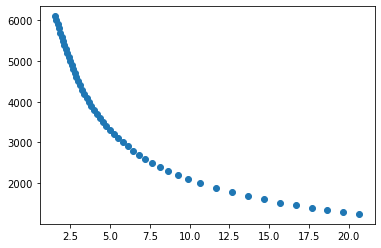

In [77]:
plt.plot(gaia17bpi_env.fuori[0].r_b/gaia17bpi_env.fuori[0].r_star, gaia17bpi_env.fuori[0].temps, 'o')

## Full-resolution models and data

In [79]:
START = 22000
END = 23000

# Full model
wav_full, lum_full = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, False)

# Single atmosphere
# wav_ATM, lum_ATM = gaia17bpi_env.disk_atm[3].wavelengths_interp, gaia17bpi_env.disk_atm[3].lums_broad

flux_full  = pyasl.unred(wav_full, lum_full*np.cos(gaia17bpi_env.fuori[0].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[0].a_v/3.1)
# flux_ATM  = pyasl.unred(wav_ATM, lum_ATM*np.cos(gaia17bpi_env.fuori[0].inc)/(2*np.pi*DIST**2), -gaia17bpi_env.fuori[0].a_v/3.1)



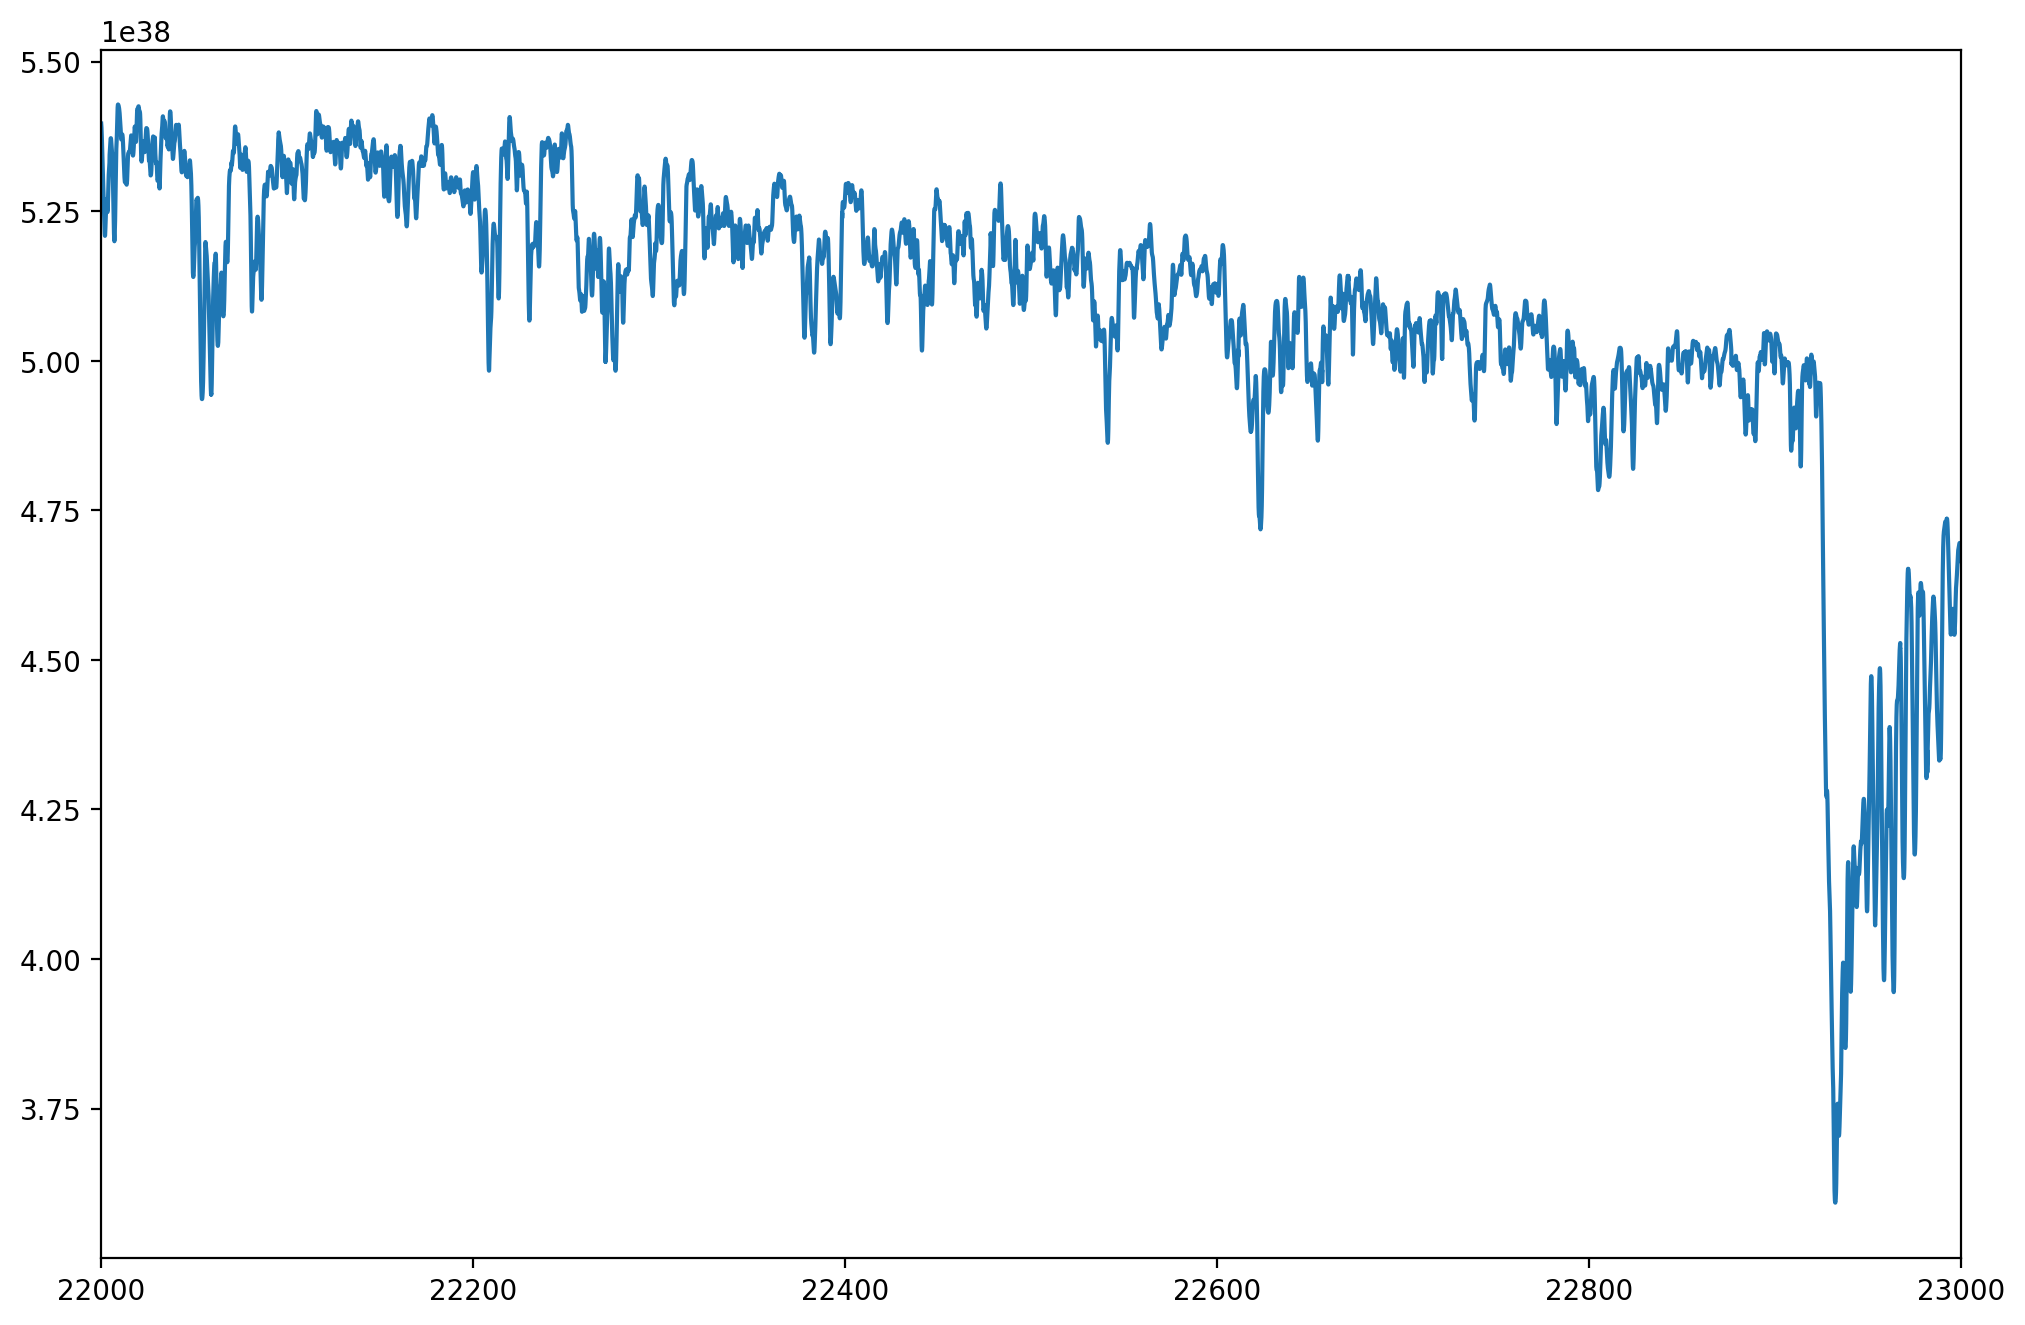

In [81]:
fig=plt.figure(figsize=(12, 8), dpi= 200)
plt.plot(wav_full, lum_full)
plt.xlim(START, END)
plt.show()

In [82]:
# with open('fu_ori_broadened_30_deg_Kband.txt', 'w') as file:
#     for i in range(len(wav_full)):
#         file.write(str(wav_full[i]) + ' ' + str(lum_full[i]) + '\n')